In [1]:
import os
import re
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from src.env import PROJECT_DIR

plt.rcParams["font.family"] = 'NanumBarunGothic'

In [78]:
file_names = [
    '20170101-20181231.csv',
    '20190101-20191231.csv',
    '20200101-20200731.csv']

In [79]:
data_dir = PROJECT_DIR / 'data' / 'raw'
media_dfs = dict()

for outlet in os.scandir(data_dir):
    if not os.path.isdir(outlet):
        continue
    dfs = []
    for f in os.scandir(outlet.path):
        if f.name not in file_names:
            continue
        dfs.append(pd.read_csv(f.path))
        
    df = pd.concat(dfs)
    media_dfs[outlet.name] = df

Compile regexes

In [80]:
square_brackets = re.compile(r'\[([^\]\[]+)\]')

sentence_break = re.compile(r'\.[\s\'"\)\>\?!]')

quotation_marks = re.compile(r'[‘’“”"\']')

open_brackets = re.compile(r'(?<=[^\s])([\[\(\{\<])')
close_brackets = re.compile(r'([\]\)\}\>])(?=[^\s])')

non_word_chars = re.compile(r'[^\uac00-\ud799A-Za-z\d\.,?!@%]+')

basic_income = re.compile(r'기본 소득')

In [25]:
square_brackets.findall('코로나 시대의 평등 [우아한 청년 발언대][전문]')

['우아한 청년 발언대', '전문']

In [84]:
non_word_chars.sub(' ', 'ㆍ기본소득이 세상을 바꾼다ㆍ오준호 지음 |개마고원 | 232쪽 | 1만4000원')

' 기본소득이 세상을 바꾼다 오준호 지음 개마고원 232쪽 1만4000원'

In [81]:
dfs = dict()
for k, df in media_dfs.items():
    v = df.copy()
    
    # Parse datetime
    v.loc[:, 'datetime'] = pd.to_datetime(v.date)
    
    # Extract article labels if it exists
    v.loc[:, 'extracted_category'] = v.title.apply(lambda title: square_brackets.findall(title))
    
    # Replace '기본 소득' with '기본소득'
    v.loc[:, 'text'] = v.text.apply(lambda text: basic_income.sub('기본소득', text))
    
    # Remove [<source>]
    source_tag = re.compile(r'^\[' + k + r'\]')
    v.loc[:, 'text'] = v.text.apply(lambda text: source_tag.sub('', text))
    
    # Remove quotation marks
    v.loc[:, 'text'] = v.text.apply(lambda text: quotation_marks.sub('', text))
    
    # Add spaces around brackets
    v.loc[:, 'text'] = v.text.apply(lambda text: open_brackets.sub(r' \1', text))
    v.loc[:, 'text'] = v.text.apply(lambda text: close_brackets.sub(r'\1 ', text))
    
    # Replace special characters with space
    v.loc[:, 'text'] = v.text.apply(lambda text: non_word_chars.sub(' ', text))
    
    # Break into sentences
    v.loc[:, 'sentences'] = v.text.apply(lambda text: [s.strip() for s in sentence_break.split(text)])
    
    v = v.set_index('datetime')
    v.drop(columns=['date'], inplace=True)
    
    # Sort
    v = v.sort_index()
    dfs[k] = v

In [82]:
dfs['경향신문'] = dfs['경향신문'][dfs['경향신문'].extracted_category.apply(lambda x: '전문' not in x)]

In [83]:
for k, v in dfs.items():
    v.drop(columns=['sentences']).to_csv(PROJECT_DIR / 'data' / 'processed' / f'articles_20170101-20200731_{k}.csv')

In [42]:
dfs['경향신문'].head()

,title,summary,text,extracted_category,sentences
datetime,,,,,
2017-01-03 18:00:00,"대선주자 인터뷰②이재명 ""나? 좋은 사람 아니라 부패척결 머슴..문재인은 점잖은 성군""",NaN,[경향신문]\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당 ...,None,[[경향신문]\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당...
2017-01-03 22:29:00,"[2017 대선의 꿈]②이재명 성남시장 ""혁명적 변화가 필요한 때..거친 야전형 장...",NaN,[경향신문]\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당 ...,2017 대선의 꿈,[[경향신문]\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당...
2017-01-04 14:57:00,아인슈타인은 옳았다..왜 노동시간을 줄여야 하는가?,NaN,"[경향신문] 인공지능과 로봇, 3D 프린팅이 주도하는 4차 산업혁명이 일자리 킬러가...",None,"[[경향신문] 인공지능과 로봇, 3D 프린팅이 주도하는 4차 산업혁명이 일자리 킬러..."
2017-01-06 19:33:00,[책과 삶]기본소득 보장은 재앙이 아니라 미래의 대안,NaN,[경향신문] ㆍ기본소득이 세상을 바꾼다ㆍ오준호 지음 |개마고원 | 232쪽 | 1만...,책과 삶,[[경향신문] ㆍ기본소득이 세상을 바꾼다ㆍ오준호 지음 |개마고원 | 232쪽 | 1...
2017-01-08 21:04:00,[사설]소득 불평등 해소 없으면 개혁 아니다,NaN,[경향신문] ㆍ구체제 청산을 위한 7대 과제\n\n덴마크에서 붙잡힌 최순실씨 딸 정...,사설,[[경향신문] ㆍ구체제 청산을 위한 7대 과제\n\n덴마크에서 붙잡힌 최순실씨 딸 ...


Save!

In [93]:
with open(PROJECT_DIR / 'data' / 'interim' / 'all_articles_1.pkl', 'wb') as fp:
    pickle.dump(dfs, fp)

Read

In [2]:
with open(PROJECT_DIR / 'data' / 'interim' / 'all_articles_1.pkl', 'rb') as fp:
    dfs = pickle.load(fp)

# Prelim analysis

## Set font

In [ ]:
# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())

print ('설정파일 위치: ', mpl.matplotlib_fname())

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# ttf 폰트 전체갯수
print(len(font_list)) 

In [64]:
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

[('NanumBarunGothic', 'C:\\Windows\\Fonts\\NanumBarunGothic.ttf'),
 ('NanumBarunGothic', 'C:\\WINDOWS\\Fonts\\NanumBarunGothic.ttf'),
 ('Nanum Pen Script', 'C:\\WINDOWS\\Fonts\\NanumPen.ttf'),
 ('NanumBarunGothic', 'C:\\Windows\\Fonts\\NanumBarunGothicLight.ttf'),
 ('NanumSquare', 'C:\\WINDOWS\\Fonts\\NanumSquareL.ttf'),
 ('NanumSquare', 'C:\\Windows\\Fonts\\NanumSquareEB.ttf'),
 ('NanumBarunGothic', 'C:\\WINDOWS\\Fonts\\NanumBarunGothicLight.ttf'),
 ('NanumSquare', 'C:\\WINDOWS\\Fonts\\NanumSquareR.ttf'),
 ('Nanum Brush Script', 'C:\\Windows\\Fonts\\NanumBrush.ttf'),
 ('NanumBarunGothic', 'C:\\Windows\\Fonts\\NanumBarunGothicBold.ttf'),
 ('NanumSquare', 'C:\\WINDOWS\\Fonts\\NanumSquareEB.ttf'),
 ('NanumSquare', 'C:\\WINDOWS\\Fonts\\NanumSquareB.ttf'),
 ('NanumBarunGothic', 'C:\\Windows\\Fonts\\NanumBarunGothicUltraLight.ttf'),
 ('NanumSquare', 'C:\\Windows\\Fonts\\NanumSquareL.ttf'),
 ('NanumBarunGothic', 'C:\\WINDOWS\\Fonts\\NanumBarunGothicUltraLight.ttf'),
 ('Nanum Brush Script', '

## Basic Info

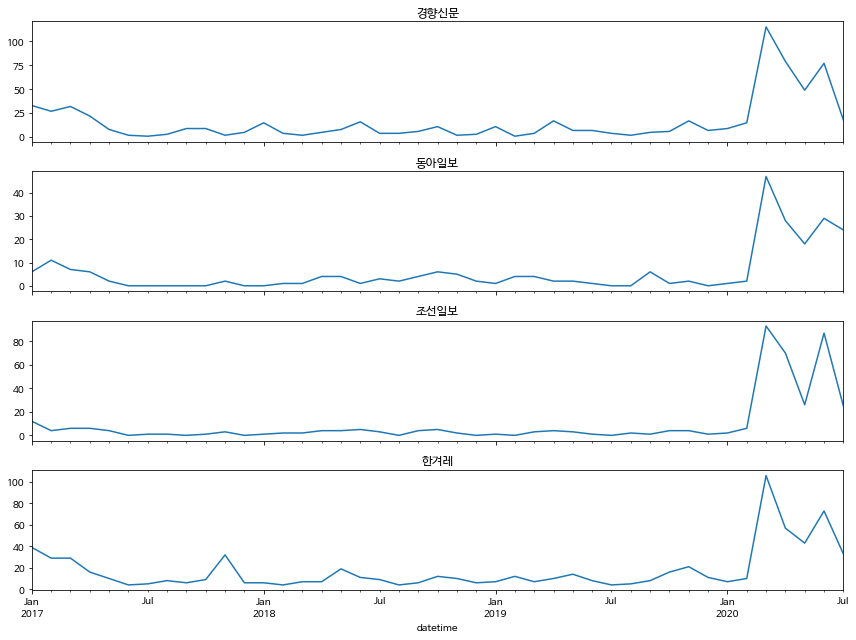

In [66]:
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
for i, (k, v) in enumerate(dfs.items()):
    v.resample('M').title.count().plot(ax=axes[i])
    axes[i].set_title(k)
    
plt.tight_layout()

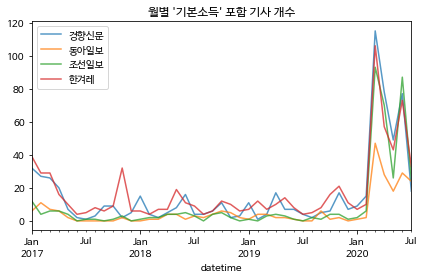

In [38]:
fig, ax = plt.subplots(1, 1, )
for k, v in dfs.items():
    v.resample('M').title.count().plot(ax=ax, label=k, alpha=0.75)
ax.legend()
ax.set_title("월별 '기본소득' 포함 기사 개수")
plt.tight_layout()

In [39]:
lengths = {k: v.shape[0] for k, v in dfs.items()}
overall_sum = sum(lengths.values())
print(lengths)
print(f"Total: {overall_sum}")

{'경향신문': 672, '동아일보': 239, '조선일보': 403, '한겨레': 746}
Total: 2060


In [77]:
dfs['경향신문'].extracted_category.value_counts().to_frame().head(20)

,extracted_category
사설,16
세상읽기,11
정동칼럼,10
경제와 세상,9
경향포럼,8
전문,7
오늘은 이런 경향,7
기고,6
편집국에서,4
헌법 11.0 다시 쓰는 시민계약,4


# Locating keyword
How shall we do it?

In [40]:
bi = re.compile(r' 기본 ?소득')

In [ ]:
sentences = df.sentences.iloc[-1]

In [9]:
res = [[m.span() for m in bi.finditer(s)] for s in sentences]
print(res)

[[], [], [], [(18, 22)], [], [], [], [], [(0, 4)], [], [], [], [], [], [], [], [], [], []]


Now count on a whole dataset

In [31]:
df = dfs['경향신문']

df.loc[:, 'kw_locs'] = df.sentences.apply(lambda sentences: [[m.span() for m in bi.finditer(s)] for s in sentences])

df.loc[:, 'kw_count'] = df.kw_locs.apply(lambda locs: sum(len(l) for l in locs))

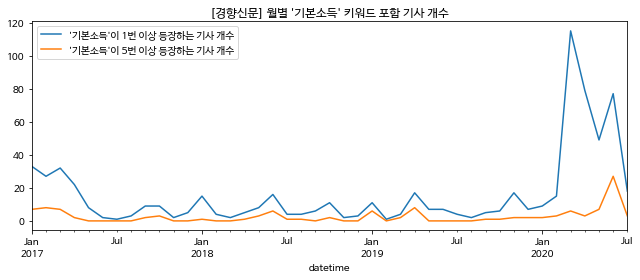

In [47]:
fig, ax = plt.subplots(figsize=(9, 4),)
df.resample('M').title.count().plot(ax=ax, label='\'기본소득\'이 1번 이상 등장하는 기사 개수')
(df.kw_count > 4).astype(int).resample('M').sum().plot(ax = ax, label='\'기본소득\'이 5번 이상 등장하는 기사 개수')
ax.set_title('[경향신문] 월별 \'기본소득\' 키워드 포함 기사 개수')
ax.legend()
plt.tight_layout()
plt.show()

In [48]:
for k, df in dfs.items():
    dfs[k].loc[:, 'kw_locs'] = df.sentences.apply(lambda sentences: [[m.span() for m in bi.finditer(s)] for s in sentences])
    dfs[k].loc[:, 'kw_count'] = df.kw_locs.apply(lambda locs: sum(len(l) for l in locs))

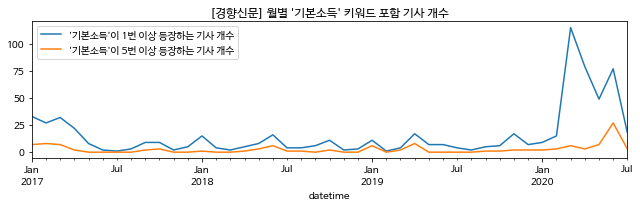

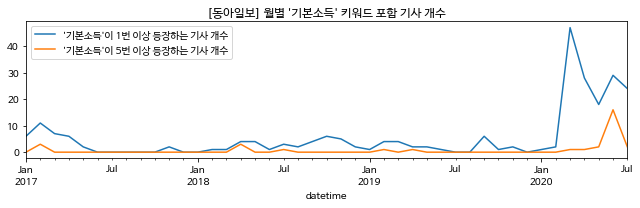

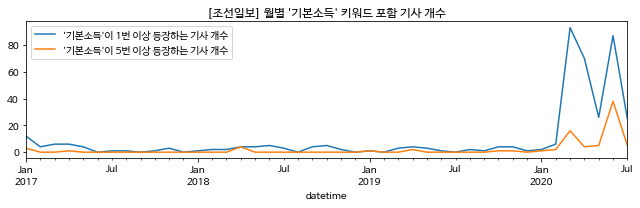

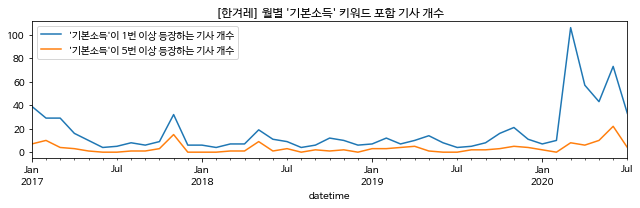

In [49]:
for k, df in dfs.items():
    fig, ax = plt.subplots(figsize=(9, 3),)
    df.resample('M').title.count().plot(ax=ax, label='\'기본소득\'이 1번 이상 등장하는 기사 개수')
    (df.kw_count > 4).astype(int).resample('M').sum().plot(ax = ax, label='\'기본소득\'이 5번 이상 등장하는 기사 개수')
    ax.set_title(f'[{k}] 월별 \'기본소득\' 키워드 포함 기사 개수')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [51]:
more_than_once = []
more_than_5 = []

for k, df in dfs.items():
    more_than_once.append(df.resample('M').title.count())
    more_than_5.append((df.kw_count > 4).astype(int).resample('M').sum())

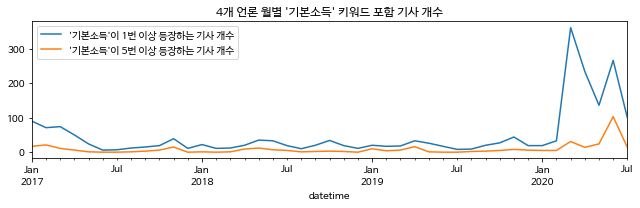

In [64]:
fig, ax = plt.subplots(figsize=(9, 3),)
sum(more_than_once).sort_index().plot(ax=ax, label='\'기본소득\'이 1번 이상 등장하는 기사 개수')
sum(more_than_5).sort_index().plot(ax = ax, label='\'기본소득\'이 5번 이상 등장하는 기사 개수')
ax.set_title('4개 언론 월별 \'기본소득\' 키워드 포함 기사 개수')
ax.legend()
plt.tight_layout()
plt.show()

In [66]:
df[df.kw_count > 4].sample().iloc[0].text

'\n\n이재명 경기지사가 성남시에서 청년배당으로 시작한 기본소득 정책을 경기도에서 점차 확대해 나가겠다고 밝혔다. 이 지사는 먼저 청년배당을 경기도 전 지역으로 확대하고, 나아가 지방세나 국토보유세를 신설해 기본소득 지급 대상을 확대해야 한다고 밝혔다. 지난 1일 경기도지사로 취임한 그는 4일 <한겨레> 와의 인터뷰에서 복지는 투자이고 지속가능한 성장 방안이라며 경기도에 기본소득위원회를 구성해서 재임 중 청년배당 등 기본소득 지급을 확대하겠다고 말했다.\n\n산후조리·교복 무상화 등 성남 3대 복지 경기 전역 확대 총예산 2000억…시·군 협력해야\n\n정부의 남북협력사업 실현시키고 서울·인천과 상시 협력체계 구축 시민 참여한 협치위 꾸릴 계획도\n\n대선 야망 위해 지위 활용 않겠다 도지사 다시 세우자 하게 만들 것\n\n- 민선 7기 도정 방향은?\n\n기본에 충실한 경기도를 만들고 싶다. 불공정, 부정의가 아니라 공정한 경쟁이 통하는 경기도, 도민이 삶 속에서 주인임을 체감하는 경기도를 만들겠다.\n\n- 성남시의 이재명 3대 무상복지는 경기도로 확대되나?\n\n3대 무상복지 정책은 도 전역에 확대하겠다. 특히 생애주기별 맞춤형 복지정책을 하겠다. 성남시에서 2016년부터 초등학교 4학년 모두에게 치과 주치의제를 시행했다. 유치에서 영구치로 바뀔 때 부모 대신 동네 치과가 신경을 써주는 것이다. 1명당 4만원 정도 비용으로 성남시 초등학교 4학년 학생 전체를 대상으로 한해 3억원 정도 들었는데, 부모들이 대만족했다. 이런 저비용 고효율의 복지 정책이 얼마든지 가능하다.\n\n- 재원이 있나?\n\n청년배당에 1800억원을 비롯해 무상산후조리와 무상교복 등 3대 무상복지 정책에 연간 2000억원 정도 예산이 들 것으로 보인다. 불요불급한 예산 조정과 철저한 세금 징수, 시·군과의 협력을 통해 재원 확보가 가능하다.\n\n- 재임 중 기본소득 정책 시범 운영을 약속했다.\n\n청년배당은 넓은 의미에서 기본소득 정책이다. 경기도 기본소득위원회를 설치해 청년배

# POS tagging

In [86]:
from konlpy.tag import Hannanum

In [87]:
hannanum = Hannanum()
# hannanum.analyze()

In [88]:
def extract_nouns(sentences):
    noun_sentences = []
    for s in sentences:
        nouns = []
        tagged_sentence = hannanum.pos(s)
        for w, t in tagged_sentence:
            if t == 'N':
                nouns.append(w)
        noun_sentences.append(nouns)
    return noun_sentences

In [89]:
for k, v in dfs.items():
    dfs[k].loc[:, 'nouns'] = v.sentences.apply(extract_nouns)

In [105]:
split_date = pd.Timestamp(2020, 2, 25)
k = '경향신문'
b = dfs[k].loc[dfs[k].index < split_date].sentences.apply(extract_nouns)
a = dfs[k].loc[dfs[k].index >= split_date].sentences.apply(extract_nouns)

In [99]:
def get_word_count(series):
    all_words = pd.concat([pd.Series(x) for x in series])
    return all_words.value_counts().to_frame().reset_index().rename(columns={'index': 'noun', 0: 'count'})

In [117]:
terms_containing_기본소득 += b_word_count.noun.tolist() + a_word_count.noun.tolist()

In [118]:
u = pd.Series(pd.Series(terms_containing_기본소득).unique()).apply(lambda x: x if '기본소득' in x else None)

In [120]:
u[u.notnull()].tolist()

['기본소득',
 '기본소득보장제',
 '기본소득제',
 '기본소득형',
 '청년기본소득',
 '기본소득권',
 '기본소득법',
 '기본소득지구네트워크',
 '기본소득당',
 '농가기본소득도입위원회',
 '청년기본소득사업',
 '기본소득하의',
 '기본소득론',
 '기본소득박람회',
 '기본소득한국네트워크',
 '재난기본소득',
 '기본소득토지세',
 '기본소득위원회',
 '재난기본소득제',
 '청년기본소득제도',
 '재난기본소득지급',
 '국민기본소득제',
 '농민기본소득',
 '정치기본소득',
 '기본소득제도',
 '언론기본소득',
 '온국민기본소득운동본부',
 '농촌기본소득',
 '기본소득안',
 '기본소득네트워크',
 '기본소득보장',
 '기본소득지방정부협의회',
 '기본소득청소년네트워크',
 '녹색기본소득',
 '기본소득운동',
 '기본소득론자들',
 '농민기본소득추진위',
 '국민기본소득',
 '기본소득용',
 '기본소득연구그룹',
 '농민기본소득추진',
 '기본소득검증',
 '필요기본소득',
 '기본소득지구',
 '기본소득연구단장',
 '농민기본소득보장제',
 '기본소득인가',
 '기본소득만',
 '기본소득인도네트워크',
 '기본소득이냐',
 '기본소득정책',
 '정치기본소득제',
 '기본소득론자',
 '시민기본소득',
 '기본소득도입',
 '국가기본소득위원회',
 '언론기본소득재단',
 '이어받아기본소득',
 '시민기본소득트러스트',
 '청년기본소득제',
 '기본소득동맹',
 '농민기본소득관',
 '기본소득프로젝트팀',
 '농민기본소득제',
 '재난기본소득법안',
 '경기도재난기본소득',
 '기본소득한국네트',
 '기본소득신진연구자네트워크',
 '시군재난기본소득',
 '경기재난기본소득',
 '기본소득사업',
 '기본소득연구포럼',
 '기본소득세',
 '기본소득이다',
 '재산기본소득',
 '기본소득모임']

In [115]:
b_word_count = get_word_count(b)

In [116]:
a_word_count = get_word_count(a)

In [102]:
d = b_word_count
d.loc[d.noun.apply(lambda x: '기본소득' in x)]

,noun,count
5,기본소득,163
387,기본소득보장제,12
441,기본소득제,11
513,기본소득형,10
1194,청년기본소득,4
2734,기본소득권,2
3302,기본소득법,1
3479,기본소득지구네트워크,1
5269,기본소득당,1
5341,농가기본소득도입위원회,1


In [103]:
d = a_word_count
d.loc[d.noun.apply(lambda x: '기본소득' in x)]

,noun,count
4,기본소득,335
10,재난기본소득,202
163,기본소득제,35
1175,청년기본소득,6
1407,기본소득토지세,5
2804,기본소득박람회,2
3718,기본소득위원회,1
3800,기본소득법,1
4340,기본소득당,1
4359,재난기본소득제,1


In [128]:
d.to_csv(PROJECT_DIR / 'data' / 'processed' / '동아일보_noun_count_20200225-.csv', index=False)

In [129]:
d.shape

(7833, 2)

In [67]:
d = pd.read_csv(PROJECT_DIR / 'data' / 'processed' / '동아일보_noun_count.csv')
e = pd.read_csv(PROJECT_DIR / 'data' / 'processed' / '한겨레_noun_count_20200225-.csv')

In [143]:
d.merge(e, on='noun', how='outer', suffixes=('_200225전', '_200225후')).fillna(0).to_csv(PROJECT_DIR / 'data' / 'processed' / '한겨레_noun_count-200225_split.csv')

In [72]:
한겨레_기본소득_포함 = d.loc[d.noun.apply(lambda x: '기본소득' in x)]

## 1. Extract prefix and suffixes



We first have to extract all nouns, then want to locate all occurrences of '기본소득' in the nouns.

We capture any prefix or suffix that surrounds '기본소득'.

In [3]:
ubi_prefix_suffix = re.compile(r'([^\s]*)기본소득([^\s]*)')

In [131]:
word = '기본소득도입'
prefix, suffix = ubi_prefix_suffix.search(word).groups()
print(prefix + ', ' + suffix)

, 도입


In [4]:
dfs['한겨레'].nouns.head()

datetime
2017-01-02 18:26:00    [[이태수꽃동네대학교, 사회복지대학원, 원장, 기본소득, 논의], [진보진영, 기본...
2017-01-02 18:36:00    [[지난해, 1월, 다보스포럼, 이후, 제4차, 산업혁명, 고용, 영향, 세계적, ...
2017-01-03 10:26:00    [[스마트, 쇼퍼, 사용, 그것, 혁명], [직장, 곽지, 38, 지난달, 22일,...
2017-01-03 11:16:00    [[이재명, 성남시장, 미국, 방위비, 분담금, 협상, 주둔비용의, 50, 미군, ...
2017-01-03 18:16:00    [[핀란드, 국, 단위, 유럽, 최초, 올해, 기본소득제, 실험, 시작], [핀란드...
Name: nouns, dtype: object

In [95]:
k = '경향신문'

pref_suf = []
for sentences in dfs[k].nouns:
    pref_suf_word = []
    for s in sentences:
        for word in s:
            if '기본소득' in word:
                prefix, suffix = ubi_prefix_suffix.search(word).groups()
                pref_suf_word.extend([f'{prefix}-{suffix}'])
    pref_suf.append(pref_suf_word)

In [68]:
split_date = pd.Timestamp(2020, 2, 25)

In [96]:
pref_suf = pd.Series(pref_suf, index=dfs[k].index)
before_pref_suf = pd.Series([x for l in pref_suf[pref_suf.index < split_date] for x in l])
after_pref_suf = pd.Series([x for l in pref_suf[pref_suf.index >= split_date] for x in l])

In [97]:
before_count = before_pref_suf.value_counts()
after_count = after_pref_suf.value_counts()

In [98]:
double_bar = before_count[_filter_count(before_count)].to_frame().reset_index().merge(after_count[_filter_count(after_count)].to_frame().reset_index(), how='outer', on='index', suffixes=('_before', '_after')).set_index('index').drop(['-'], axis=0)

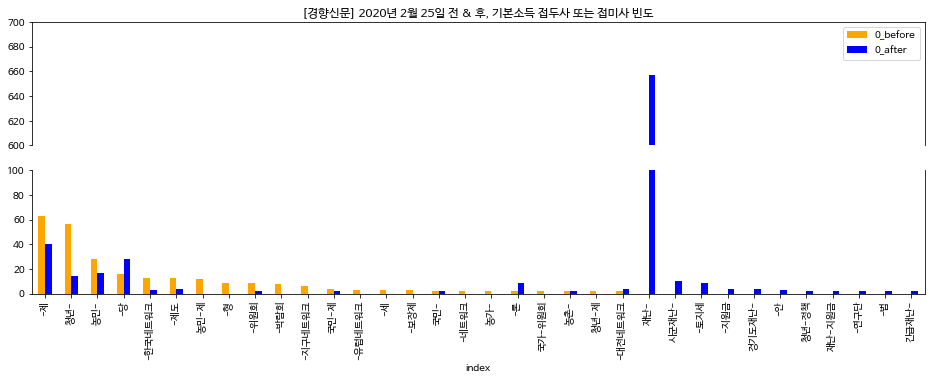

In [101]:
# def _filter_count(_ser):
#     return (_ser > 1) & (_ser < 900)

fig, axes = plt.subplots(2, 1, figsize=(16, 5))
double_bar.plot.bar(color=['orange', 'blue'], ax=axes[0], title=f'[{k}] 2020년 2월 25일 전 & 후, 기본소득 접두사 또는 접미사 빈도')
double_bar.plot.bar(color=['orange', 'blue'], ax=axes[1], legend=False)
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].get_xaxis().set_visible(False)
# axes[0].get_xaxis().set_label('')
axes[0].set_ylim(600, 700)
axes[1].set_ylim(0, 100)
axes[0].legend()

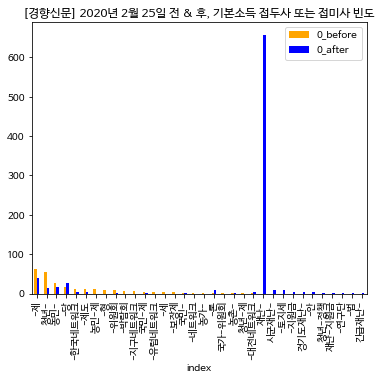

In [99]:
double_bar.plot.bar(color=['orange', 'blue'], figsize=(6, 5), title=f'[{k}] 2020년 2월 25일 전 & 후, 기본소득 접두사 또는 접미사 빈도')

## Other keywords

In [102]:
dfs[k].nouns.head()

datetime
2017-01-03 18:00:00    [[촛불정국, 야권, 유력, 대선주자, 발돋움, 더불어민주당, 이재명, 성남시장, ...
2017-01-03 22:29:00    [[촛불정국, 야권, 유력, 대선주자, 발돋움, 더불어민주당, 이재명, 성남시장, ...
2017-01-04 14:57:00    [[인공지능, 로봇, 3D, 프린팅, 주도하, 4차, 산업혁명, 일자리, 킬러, 수...
2017-01-06 19:33:00    [[기본소득, 세상, 오준호, 개마고원, 232쪽, 1만4000원, 핀란드, 기본소...
2017-01-08 21:04:00    [[구체제, 청산, 7대, 과제, 덴마크, 최순실씨, 정유라씨, 패딩, 차림], [...
Name: nouns, dtype: object

1. First find any keyword containing '기본소득' (even with prefix/suffix)
2. Then find sentences before it & after it
3. For that sentence & before & after, get all nouns, and how far away each noun is from the keyword containing '기본소득'

In [3]:
def get_kw_index(noun_sentences):
    locs = []
    for i, noun_sentence in enumerate(noun_sentences):
        for j, word in enumerate(noun_sentence):
            if '기본소득' in word:
                locs.append((i, j))
    return np.asarray(locs)

In [121]:
s = dfs[k].nouns.apply(get_bi_index)

In [122]:
s.sample(10)

datetime
2019-11-23 17:36:00    [(6, 3), (7, 3), (45, 6), (60, 4), (61, 2), (6...
2020-04-06 21:21:00                                            [(18, 4)]
2020-05-30 03:00:00                                  [(12, 16), (32, 4)]
2020-03-08 15:33:00    [(0, 12), (3, 0), (4, 1), (5, 1), (6, 4), (6, ...
2020-02-23 20:56:00                                  [(24, 3), (29, 10)]
2017-03-20 21:18:00                                            [(13, 3)]
2017-10-12 21:48:00                                           [(14, 16)]
2017-04-02 18:40:00                 [(10, 0), (11, 8), (12, 0), (13, 7)]
2020-04-13 21:07:00                                             [(8, 2)]
2018-10-07 10:04:00               [(16, 2), (17, 21), (18, 10), (20, 3)]
Name: nouns, dtype: object

In [4]:
import numpy as np

In [56]:
def get_sentence_loc_tuple(row):
    bi_indices = row.kw_index
    n_sentences = len(row.sentences)
    if bi_indices.shape[0] > 0:
        x = np.unique(bi_indices[:, 0])
    else:
        x = np.asarray([])
    _prev = x - 1
    _next = x + 1
    
    _prev = _prev[_prev >= 0]
    _next = _next[_next < n_sentences]
    
    _prev = np.setdiff1d(_prev, x)
    _next = np.setdiff1d(np.setdiff1d(_next, x), _prev)
    return (_prev, x, _next)

In [90]:
for k, v in dfs.items():
    dfs[k].loc[:, 'kw_index'] = v.nouns.apply(get_kw_index)
    dfs[k].loc[:, 'sentence_loc_tuple'] = v.apply(get_sentence_loc_tuple, axis=1)

In [7]:
dfs[k].head()

,title,summary,text,extracted_category,sentences,nouns,kw_index,sentence_loc_tuple
datetime,,,,,,,,
2017-01-02 18:26:00,[왜냐면] 한국에서 기본소득이 가능할까? / 이태수,NaN,이태수꽃동네대학교 사회복지대학원 원장 기본소득에 대한 논의가 서서히 끓어오르고 있...,[왜냐면],[이태수꽃동네대학교 사회복지대학원 원장 기본소득에 대한 논의가 서서히 끓어오르고 있...,"[[이태수꽃동네대학교, 사회복지대학원, 원장, 기본소득, 논의], [진보진영, 기본...","[[0, 3], [1, 1], [3, 14], [8, 3], [8, 11], [9,...","([2, 7, 11, 18, 24], [0, 1, 3, 8, 9, 10, 12, 1..."
2017-01-02 18:36:00,[한겨레 사설] 밀려오는 4차 산업혁명의 '일자리 충격',NaN,지난해 1월 다보스포럼 이후 제4차 산업혁명이 고용에 미칠 영향이 세계적 관심사로...,[한겨레 사설],[지난해 1월 다보스포럼 이후 제4차 산업혁명이 고용에 미칠 영향이 세계적 관심사로...,"[[지난해, 1월, 다보스포럼, 이후, 제4차, 산업혁명, 고용, 영향, 세계적, ...","[[17, 11]]","([16], [17], [18])"
2017-01-03 10:26:00,무인매장·무인공장·무인운전..노동자가 사라진다,새해기획-4차 산업혁명인간혁명의 갈림길 ① 인간 노동 존중 않는 혁명은 실패한다,스마트 쇼퍼 사용해보니 그것은 혁명이었다. 직장인 곽지은 38 씨는 지난달 22일...,[],"[스마트 쇼퍼 사용해보니 그것은 혁명이었다, 직장인 곽지은 38 씨는 지난달 22일...","[[스마트, 쇼퍼, 사용, 그것, 혁명], [직장, 곽지, 38, 지난달, 22일,...","[[67, 6]]","([66], [67], [68])"
2017-01-03 11:16:00,"이재명 ""미군 방위비 분담금 낮춰야..자주국방도 대비""","'김현정의 뉴스쇼' 대선주자 인터뷰 ""유승민, 사드 주장해놓고 지역구에는 안 된다는...",이재명 성남시장이 미국과 방위비 분담금 협상을 해 주둔비용의 50%로 낮춰야 하며...,[],[이재명 성남시장이 미국과 방위비 분담금 협상을 해 주둔비용의 50%로 낮춰야 하며...,"[[이재명, 성남시장, 미국, 방위비, 분담금, 협상, 주둔비용의, 50, 미군, ...","[[16, 0]]","([15], [16], [17])"
2017-01-03 18:16:00,"핀란드, 기본소득 실험..매달 71만원 그냥 준다",2000명에 2년간 실험..취업해도 지급 빈곤감소·고용확대 효과 면밀 검토뒤 성과...,핀란드가 국가 단위로는 유럽 최초로 올해부터 기본소득제 실험을 시작했다. 핀란드 ...,[],"[핀란드가 국가 단위로는 유럽 최초로 올해부터 기본소득제 실험을 시작했다, 핀란드 ...","[[핀란드, 국, 단위, 유럽, 최초, 올해, 기본소득제, 실험, 시작], [핀란드...","[[0, 6], [1, 20], [3, 0], [4, 7], [5, 6], [6, ...","([2, 9, 17], [0, 1, 3, 4, 5, 6, 10, 11, 12, 13..."


In [8]:
def extract_current_sentence_kws(row):
    noun_sentences = row.nouns
    kw_indices = np.asarray(row.kw_index)
    _prev, current, _next = row.sentence_loc_tuple
    
    current_kws = []
    
    for i in range(len(current)):
        kw_sent_idx = kw_indices[kw_indices[:, 0] == i, 1]
        slice_idx = np.r_[-1, kw_sent_idx, len(noun_sentences[i])+1]
        
        for start_idx, end_idx in zip(slice_idx[:-1], slice_idx[1:]):
            current_kws.extend(noun_sentences[i][start_idx+1:end_idx-1])
    
    return current_kws

In [194]:
current_kws = dict()
for k, v in dfs.items():
    current_sentence_kws = v.apply(extract_current_sentence_kws, axis=1)
    before_kws = pd.Series(np.concatenate(current_sentence_kws[current_sentence_kws.index < split_date].apply(lambda x: np.asarray(x)).tolist())).value_counts()
    after_kws = pd.Series(np.concatenate(current_sentence_kws[current_sentence_kws.index >= split_date].apply(lambda x: np.asarray(x)).tolist())).value_counts()
    current_kws[k] = (before_kws, after_kws)

In [202]:
current_kws_counts = dict()
for k, v in current_kws.items():
    b, a = v
    current_kws_counts[k] = b.to_frame().join(a.to_frame(), lsuffix='_before', rsuffix='_after').rename(columns={'0_before': 'before', '0_after': 'after'})

In [203]:
for k, v in current_kws_counts.items():
    v.to_csv(PROJECT_DIR / 'data' / 'processed' / f'keywords_in_current_sentence-{k}.csv')

Extract sentences surrounding the keyword..

In [40]:
np.sort(np.concatenate(dfs['한겨레'].sentence_loc_tuple.iloc[0]))

array([ 0,  1,  2,  2,  3,  4,  7,  8,  9, 10, 11, 11, 12, 13, 18, 19, 20,
       24, 25])

In [18]:
def extract_relevant_sentences(row):
    sentences = np.asarray(row.sentences)
    relevant_sentence_idx = np.sort(np.concatenate(row.sentence_loc_tuple).astype(int))
    return list(sentences[relevant_sentence_idx])

In [91]:
for k, v in dfs.items():
    dfs[k].loc[:, 'relevant_sentences'] = v.apply(extract_relevant_sentences, axis=1)

In [37]:
s = dfs['경향신문'].relevant_sentences.sample()
print(s.index[0])
print(s.iloc[0])

2020-06-02 10:53:00
['홍 부총리 겸 기획재정부 장관은 1일 2020년 하반기 경제정책방향 정부 합동브리핑 후 질의응답에서 2차 긴급재난지원금 지급 가능성을 묻는 질문에 아직까지 정부는 전혀 검토한 바 없다며 재정당국을 맡는 입장에서 저는 추가적인 긴급재난지원금 지급은 전혀 생각하지 않고 있다고 말했다', '반면 이 지사는 코로나19가 종식되더라도 경제는 상당 기간 나빠질 가능성이 있기 때문에 당연히 최소한 두세 번 정도는 재난기본소득 지급을 더 해야 할 것이라며 가장 효율적인 방법으로 경제 순환을 원활하게 하려면 공급보다는 수요를 보강해야 정상적인 순환이 가능하다', '2 3차례 정도 재난기본소득을 지원하는 것이 훨씬 도움이 된다고 주장해왔다', '도는 지난 4월부터 경기도 재난기본소득 1인당 10만원 을 지급한 이후 실제로 지역경제를 살리는 효과가 다양하게 나타나고 있다고 보고 있다', '한국신용데이터 조사를 토대로 전국 주요 지역 자영업자의 카드 매출 비율을 살펴본 결과, 경기도의 경우 4월 셋째주 4월 13 19일 95%에서 5월 셋째 주 5월 11 17일 107%까지 전년 같은 기간보다 상승했다는 점을 들었다', '한국신용데이터 조사를 토대로 전국 주요 지역 자영업자의 카드 매출 비율을 살펴본 결과, 경기도의 경우 4월 셋째주 4월 13 19일 95%에서 5월 셋째 주 5월 11 17일 107%까지 전년 같은 기간보다 상승했다는 점을 들었다', '아울러 재난기본소득이 자영업자 매출과 골목상권 활성화에 영향을 줬다는 도민 대상 자체 설문조사도 결과도 제시했다', '도는 지난 15 16일 한국리서치에 의뢰해 도민 1000명을 대상으로 경기도 재난기본소득 효과 및 만족도 조사를 한 결과, 응답자의 80%가 평소 가던 대형마트 대신 동네가게를 이용했다고 답했다', '이를 경험한 도민의 85%는 재난기본소득을 사용할 목적이 아니더라도 동네가게나 전통시장을 재방문할 의사가 있다고 응답했다', '경태영 기자 kyeong@kyunghyang.com'

In [59]:
print_rel_sent('경향신문', '2017-01-11 15:30:00')

2017-01-11 15:30:00
['아울러 청년배당 정책에 대해 청년 지원 정책이자 지역상권 활성화 정책이라고 강조했다', '그러면서 헬조선, 대한민국이라는 지옥 탈출이 꿈이고 국가로부터 버림받은 청년을 위해 논란을 감수하고 했다면서 일부 선별적 시행론을 두고는 부자 아이들 골라내는 비용이 오히려 더 든다며 기본소득에 관한 전 세계적 논의 움직임을 소개했다', '이 시장은 신 구시가지 격차와 갈등이 자연스럽게 해소됐다']


In [60]:
print_rel_sent('경향신문', '2020-04-20 20:47:00')

2020-04-20 20:47:00
['그간 어둡다고 눈길을 두지 않았던 곳, 불가능하다고 거들떠보지 않았던 곳을 다시 보자', '그런 곳에 있는 열쇠 중 하나가 기본소득을 통해 농업을 되살리는 것이다', '재난기본소득에서 한 발 나아간 상시적 농민기본소득이 미래로 가는 여러 문 가운데 하나를 열어젖힐 것이다', '마스크보다 쌀이다']


In [61]:
print_rel_sent('경향신문', '2020-03-21 18:30:00')

2020-03-21 18:30:00
['3선이지만 구로는 초선 김용태 후보 측 다짐 기자의 휴대폰에 들어오는 수많은 선거홍보 문자 중에 김용태 후보의 메시지는 유독 눈에 띈다', '여권 대선주자들의 재난기본소득 주장을 구체적으로 거론하며 비판한다', '어제는 이재명 경기지사, 오늘은 박원순 서울시장을 비판하는 식이다', '95% 신뢰수준에서 4.4%p 오차 수준', '자세한 조사결과는 중앙선거여론조사심의위원회 홈페이지 재난기본소득, 험지출마에 대한 입장 김용태 후보는 자신이 공천을 받고 들어와 1주일 만에 코로나가 터졌다고 밝혔다', '그는 재난기본소득 문제 등 정책이슈와 함께 1970 80년대 개발시대 구로공단을, 2000년대 초반 IT디지털단지를 넘어 2020년대 4차 산업 핀테크의 메카로 만드는 것을 지역공약으로 내세웠다', '그는 코로나 방역싸움이 국민의 안전을 위협하는 1차 방역전선이라면 2차 전선은 국민고용을 위협하는 해고와의 전쟁이라며 불특정 다수에게 100만원씩 주는 것이 아닌 서민을 고용하고 있는 자영업자, 중소기업에 핀포인트로 몰빵해 지원해야 2차 전선에서 효과를 볼 수 있다고 주장했다', '사실 추가경정예산도 다 필요 없어요', '재난기본소득 지급 해법은 상대방 윤건영 후보보다 유력 대권주자들, 박원순 서울시장이나 이재명 경기지사, 김경수 경남도지사 등이 주장하는 거 아닙니까', '당에서 주장하니 윤 후보도 동의하는 거죠']


In [62]:
print_rel_sent('경향신문', '2020-03-30 23:03:00')

2020-03-30 23:03:00
['서울, 공무원 포함 대구, 비정규직 공무원까지 제외 논란 경기 도민 이라도 어디 시민인가에 따라 최대 40만원 차 서울, 대구, 경기 등 지방자치단체들이 코로나19 경제 여파에 대응하기 위해 내놓은 재난기본소득 등 다양한 생계지원금 대책을 두고 저마다 다른 지급 기준 때문에 논란이 불거지고 있다', '다수 지자체가 지급 상한선으로 삼은 소득 기준이 최저임금과 엇비슷하다는 점에서 지원 규모가 충분하지 않다는 지적도 나온다', '불안정 노동환경에 놓여 있을 가능성이 높은 최저임금 노동자가 지원 대상에서 제외되는 셈이다', '경기도는 소득 수준과 상관없이 1인당 10만원씩 재난기본소득을 지급할 예정이지만, 같은 도민일지라도 어느 시민인지에 따라 차이가 나게 생겼다', '경기도 내 14개 시 군은 자체적인 재난기본소득을 추가 지급하기로 했는데, 그 금액은 5만원에서 최대 40만원까지 차이가 난다', '나아가 경기도는 이날 자체 재난기본소득을 편성한 시 군에 한정해 주민 1인당 1만원꼴로 특별조정교부사업 재원을 지원하겠다고 밝혔다', '보편적 지원이 아닌 선별지원을 하는 고양, 파주, 성남, 용인, 평택, 시흥시 등 6곳과 재난기본소득 계획을 발표하지 않은 11곳 등 17곳은 대상에서 제외된다', '각 시 군에 재난기본소득 도입을 유도하기 위한 인센티브 성격이 있지만, 시 군별 금액 격차에 더해 재정 격차까지 키울 것이란 지적도 나온다', '기초단체 줄 세우기란 비판도 있다', '경기도는 앞서 부천시장이 재난기본소득에 반대하자 부천시를 지급 대상에서 제외한다는 방침을 밝혀 논란이 됐다', '채진원 경희대 공공거버넌스연구소 교수는 수평적 협력, 의견수렴보다는 관 중심의 사고를 보여주면서 여러 반발을 낳고 있다며 민주적 거버넌스보다는 권위주의적 리더십이 드러나는 상황이라고 지적했다.']


In [63]:
print_rel_sent('경향신문', '2020-06-02 10:53:00')

2020-06-02 10:53:00
['홍 부총리 겸 기획재정부 장관은 1일 2020년 하반기 경제정책방향 정부 합동브리핑 후 질의응답에서 2차 긴급재난지원금 지급 가능성을 묻는 질문에 아직까지 정부는 전혀 검토한 바 없다며 재정당국을 맡는 입장에서 저는 추가적인 긴급재난지원금 지급은 전혀 생각하지 않고 있다고 말했다', '반면 이 지사는 코로나19가 종식되더라도 경제는 상당 기간 나빠질 가능성이 있기 때문에 당연히 최소한 두세 번 정도는 재난기본소득 지급을 더 해야 할 것이라며 가장 효율적인 방법으로 경제 순환을 원활하게 하려면 공급보다는 수요를 보강해야 정상적인 순환이 가능하다', '2 3차례 정도 재난기본소득을 지원하는 것이 훨씬 도움이 된다고 주장해왔다', '도는 지난 4월부터 경기도 재난기본소득 1인당 10만원 을 지급한 이후 실제로 지역경제를 살리는 효과가 다양하게 나타나고 있다고 보고 있다', '한국신용데이터 조사를 토대로 전국 주요 지역 자영업자의 카드 매출 비율을 살펴본 결과, 경기도의 경우 4월 셋째주 4월 13 19일 95%에서 5월 셋째 주 5월 11 17일 107%까지 전년 같은 기간보다 상승했다는 점을 들었다', '아울러 재난기본소득이 자영업자 매출과 골목상권 활성화에 영향을 줬다는 도민 대상 자체 설문조사도 결과도 제시했다', '도는 지난 15 16일 한국리서치에 의뢰해 도민 1000명을 대상으로 경기도 재난기본소득 효과 및 만족도 조사를 한 결과, 응답자의 80%가 평소 가던 대형마트 대신 동네가게를 이용했다고 답했다', '이를 경험한 도민의 85%는 재난기본소득을 사용할 목적이 아니더라도 동네가게나 전통시장을 재방문할 의사가 있다고 응답했다', '경태영 기자 kyeong@kyunghyang.com']


In [73]:
dfs[source][dfs[source].index == pd.Timestamp('2018-05-31 04:32:00')].text.iloc[0]

'이탈리아의 정치 불안이 유럽 전체를 공포로 몰아넣고 있다. 글로벌 금융시장도 요동치고 있다. 세르지오 마타렐라 이탈리아 대통령과 원내 다수당인 포퓰리즘 정당 오성운동 및 동맹당 이 벌이는 맞대결에서 EU 유럽연합 탈퇴를 공언해 온 포퓰리즘 세력이 이길 가능성이 높기 때문이다. 유로존 유로화를 사용하는 19개국 3위 경제 대국인 이탈리아가 EU에서 빠져나오면 EU의 존립이 위태로워진다는 두려움이 고스란히 표출된다. 이탈리아 10년 만기 국채 금리는 29일 현지 시각 연 3.18%로 0.51%포인트 급등했다. 글로벌 투자자들이 내던져 하루 만에 가치가 급락한 것이다. 유로존에서 안전 자산으로 인식되는 독일 국채와 이탈리아 국채의 금리 차이도 3%포인트 가까이 벌어졌다. 유럽 증시에 이어 열린 뉴욕 증시와 아시아 증시도 줄줄이 내려앉았다. 최근 유동성 위기가 심해지고 있는 아르헨티나 등 중남미, 터키 등 유럽 국가로 전염될 수 있다는 우려도 나온다. 세계적 투자자인 조지 소로스는 EU가 큰 위기를 맞이하고 있다며 세계가 금융 위기를 맞을 수도 있다고 경고했다. 월스트리트저널은 2010년대 초 국채 가격 급락이 은행 부실과 예금 인출 구제금융으로 이어지는 사태가 연상된다고 했다. 해외 큰손들은 이탈리아 정치권에서 포퓰리즘 세력 부상을 우려하며 지켜보고 있다. 마타렐라 대통령은 오성운동과 동맹당의 반 EU 행보를 저지하기 위해 지난 28일 IMF 국제통화기금 고위직을 지낸 카를로 코타렐리를 과도 총리로 지명했다. 정국 수습을 자신이 임명한 총리에게 맡긴 뒤 내년에 총선을 다시 치르자는 주장이다. 지난 3월 총선에서 원내 1당과 2당을 차지한 오성운동과 동맹당은 이에 반발하고 있다. 대통령이 임명한 코타렐리 총리 후보자를 신임 투표에서 부결시킨 뒤 7월에 조기 총선을 치르겠다고 나선다. 의석 55%를 차지하고 있는 두 당이 원하는 대로 흘러갈 확률이 높은 상황이다. 해외 투자자들이 패닉에 빠진 이유는 이탈리아 여론이 오성운동과 동맹당 등 포퓰리즘 정당에 유리하게 굴러가

In [98]:
source = '동아일보'
print("# 2020/2/25 전")
for datetime in dfs[source][dfs[source].index < split_date].sample(5).sort_index().index:
    print_article(source, datetime)
    print("")

print("# 2020/2/25 후")
for datetime in dfs[source][dfs[source].index >= split_date].sample(5).sort_index().index:
    print_article(source, datetime)
    print("")

# 2020/2/25 전
2017-02-10 03:03:00
수조원 예산 들여 공무원 양산? 세금 내는 민간 체력만 고갈
[일자리 공약 포퓰리즘 우려]재원조달 방안 빠진 '장밋빛 공약'
 땜질식 일자리 공약 논란 더불어민주당 대선 주자인 문재인 전 대표와 이재명 경기 성남시장은 일자리 창출 해법으로 공공부문 일자리 확충과 근로시간 단축을 내걸었다. 청년 실업을 해결하기 위해서는 공공부문 일자리 창출과 대기업 근로시간 단축으로 양질의 일자리를 만들어야 한다는 취지다. 일자리 대통령이 되겠다라고 선언한 문 전 대표는 소방 경찰 복지 등 공공부문에서 81만 개, 근로시간 단축을 통해 50만 개 등 일자리 131만 개를 만들겠다고 약속했다. 문 전 대표는 이날 국민성장 주최 포럼에서 아직도 일자리는 민간 기업이 만드는 것이라고 말씀하는 분들이 있는데 일자리 문제의 절박성을 모르는 것이라며 공공부문 일자리 마련이 민간부문 일자리 증가의 마중물이 될 것이라고 말했다. 이재명 성남시장은 근로시간 단축과 공공부문 사회적 일자리 확대로 일자리 269만 개를 만들겠다고 밝혔다. 바른정당 유승민 의원은 칼퇴근법 등 근로시간 단축, 남경필 경기도지사는 기본근로 보장을 일자리 창출 대책으로 내놨다. 하지만 이런 공약을 실현하기 위해서는 예산이 최소 수조 원에서 수십조 원이 필요하다는 지적이 나온다. 국민의당 안철수 전 대표는 6일 문 전 대표의 일자리 공약에 대해 필요한 예산이 매년 30조 원 정도로 추정된다라고 비판했다. 이에 문 전 대표 측 관계자는 일자리 81만 개를 창출할 경우 매년 4조 5조 원씩 5년간 21조5050억 원이 필요하다라고 해명했다. 이에 새누리당 이현재 정책위의장은 연간 4조 5조 원이라면 월 50만 원짜리 아르바이트생을 모집하는 셈이라며 공공일자리 81만 개는 보여 주기식 정책이라며 공세를 강화했다. 또 대선 주자들은 저출산 해소와 일자리 나누기를 위해 근로시간 단축은 불가피하다고 입을 모은다. 하지만 근로시간 단축 역시 추가적인 예산 투입이 필요한 상황이

In [97]:
def print_rel_sent(source, datetime):
    datetime = pd.Timestamp(datetime)
    s = dfs[source].relevant_sentences[dfs[source].index == datetime]
    print(s.index[0])
    print(s.iloc[0])
    
def print_article(source, datetime):
    datetime = pd.Timestamp(datetime)
    row = dfs[source][dfs[source].index == datetime].iloc[0]
    
    print(row.name)
    print(row.title)
    print(row.summary)
    print(row.text)
    


LDA

In [3]:
dfs['한겨레'].head()

,title,summary,text,extracted_category,sentences,nouns,kw_index,sentence_loc_tuple,relevant_sentences
datetime,,,,,,,,,
2017-01-02 18:26:00,[왜냐면] 한국에서 기본소득이 가능할까? / 이태수,NaN,이태수꽃동네대학교 사회복지대학원 원장 기본소득에 대한 논의가 서서히 끓어오르고 있...,[왜냐면],[이태수꽃동네대학교 사회복지대학원 원장 기본소득에 대한 논의가 서서히 끓어오르고 있...,"[[이태수꽃동네대학교, 사회복지대학원, 원장, 기본소득, 논의], [진보진영, 기본...","[[0, 3], [1, 1], [3, 14], [8, 3], [8, 11], [9,...","([2, 7, 11, 18, 24], [0, 1, 3, 8, 9, 10, 12, 1...",[이태수꽃동네대학교 사회복지대학원 원장 기본소득에 대한 논의가 서서히 끓어오르고 있...
2017-01-02 18:36:00,[한겨레 사설] 밀려오는 4차 산업혁명의 '일자리 충격',NaN,지난해 1월 다보스포럼 이후 제4차 산업혁명이 고용에 미칠 영향이 세계적 관심사로...,[한겨레 사설],[지난해 1월 다보스포럼 이후 제4차 산업혁명이 고용에 미칠 영향이 세계적 관심사로...,"[[지난해, 1월, 다보스포럼, 이후, 제4차, 산업혁명, 고용, 영향, 세계적, ...","[[17, 11]]","([16], [17], [18])",[4차 산업혁명이 가져올 생산성 향상의 과실을 재분배하기 위한 제도 도입도 빼놓을 ...
2017-01-03 10:26:00,무인매장·무인공장·무인운전..노동자가 사라진다,새해기획-4차 산업혁명인간혁명의 갈림길 ① 인간 노동 존중 않는 혁명은 실패한다,스마트 쇼퍼 사용해보니 그것은 혁명이었다. 직장인 곽지은 38 씨는 지난달 22일...,[],"[스마트 쇼퍼 사용해보니 그것은 혁명이었다, 직장인 곽지은 38 씨는 지난달 22일...","[[스마트, 쇼퍼, 사용, 그것, 혁명], [직장, 곽지, 38, 지난달, 22일,...","[[67, 6]]","([66], [67], [68])","[개인이 각자 대안을 찾을 때까지 단기적으로 사회가 버팀목이 되어야 한다는 뜻이다,..."
2017-01-03 11:16:00,"이재명 ""미군 방위비 분담금 낮춰야..자주국방도 대비""","'김현정의 뉴스쇼' 대선주자 인터뷰 ""유승민, 사드 주장해놓고 지역구에는 안 된다는...",이재명 성남시장이 미국과 방위비 분담금 협상을 해 주둔비용의 50%로 낮춰야 하며...,[],[이재명 성남시장이 미국과 방위비 분담금 협상을 해 주둔비용의 50%로 낮춰야 하며...,"[[이재명, 성남시장, 미국, 방위비, 분담금, 협상, 주둔비용의, 50, 미군, ...","[[16, 0]]","([15], [16], [17])",[북한에 돈 주면서 총 쏴달라고 하는 집단이라며 국가 존속에 가장 중요한 안보 문제...
2017-01-03 18:16:00,"핀란드, 기본소득 실험..매달 71만원 그냥 준다",2000명에 2년간 실험..취업해도 지급 빈곤감소·고용확대 효과 면밀 검토뒤 성과...,핀란드가 국가 단위로는 유럽 최초로 올해부터 기본소득제 실험을 시작했다. 핀란드 ...,[],"[핀란드가 국가 단위로는 유럽 최초로 올해부터 기본소득제 실험을 시작했다, 핀란드 ...","[[핀란드, 국, 단위, 유럽, 최초, 올해, 기본소득제, 실험, 시작], [핀란드...","[[0, 6], [1, 20], [3, 0], [4, 7], [5, 6], [6, ...","([2, 9, 17], [0, 1, 3, 4, 5, 6, 10, 11, 12, 13...","[핀란드가 국가 단위로는 유럽 최초로 올해부터 기본소득제 실험을 시작했다, 핀란드 ..."


In [14]:
for k, v in dfs.items():
    v.relevant_sentences.apply(
        lambda x: '. '.join(x)
    ).reset_index(
    ).to_csv(
        PROJECT_DIR / 'data' / 'processed' / f'{k}-relevant_sentences.csv', index=False, encoding='cp949'
    )

In [16]:
df = pd.read_csv(PROJECT_DIR / 'data' / 'processed' / f'동아일보-relevant_sentences.csv', encoding='cp949')

In [17]:
df

,datetime,relevant_sentences
0,2017-01-13 03:03:00,반값 등록금 실현에 필요한 예산만 적어도 5000억 원이 들지만 충분히 가능하다는 ...
1,2017-01-18 03:03:00,그는 정책은 의지의 문제이고 용기의 문제라며 나는 말하면 다 해 버린다라고 강조했다...
2,2017-01-23 11:06:00,그는 공정경제질서 회복을 위해 이 시대 최고 권력 재벌체제를 해체해야 한다고 주장하...
3,2017-01-24 03:02:00,"이어 이 부회장의 구속을 말할 수 없는 사람은 삼성과 싸울 수도 없는 사람이고, 삼..."
4,2017-01-24 03:03:00,2008년 글로벌 금융위기 이후 미국 오바마 정부와 일본 아베 정부가 양적 완화 정...
...,...,...
234,2020-07-28 14:16:00,이 경기지사는 28일 경기도청에서 기자회견을 열고 경기도 부동산 주요 대책을 발표했...
235,2020-07-29 03:01:00,주식 백지신탁제와 유사한 부동산 백지신탁제를 정부 차원에서 도입해 달라는 요청이 받...
236,2020-07-30 14:02:00,김 위원장은 이날 국회에서 열린 비상대책위원회의에서 정부가 코로나19로 어려움을 겪...
237,2020-07-30 17:46:00,이 의원과 이 지사는 이날 대화 중 상당 시간을 부동산 정책에 할애했다. 이 지사가...
